In [1]:
import tensorflow as tf

2024-04-09 14:29:12.794917: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-09 14:29:16.611477: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
from tensorflow import keras as keras
from keras import layers as layers

In [3]:
import os, timeit
from skimage.filters import threshold_otsu
import numpy as np
from math import inf as inf

In [4]:
import pandas as pd

In [5]:
from spectral.io import envi as envi
from spectral import imshow

In [6]:
from sklearn.decomposition import IncrementalPCA

In [7]:
import sys

In [8]:
import random

tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

In [9]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(physical_devices[1], 'GPU')

Num GPUs Available:  2


In [10]:
from sys import platform
DATA_DIRECTORY = ""
SLASH = ""
if platform == "linux" or platform == "linux2":
    DATA_DIRECTORY = "/home/tyagi/Desktop/wheat/data/BULK/"
    SLASH = "/"
elif platform == "win32":
    DATA_DIRECTORY = "D:\wheat\data\BULK\\"
    SLASH="\\"

In [11]:
#Constants
BAND_NUMBER = 60
FILLED_AREA_RATIO = 0.9
TRAIN_IMAGE_COUNT = 1200
VAL_IMAGE_COUNT = 400
TEST_IMAGE_COUNT = 400
NUM_VARIETIES = 4

IMAGE_WIDTH = 30
IMAGE_HEIGHT = 30

In [12]:
ACTIVATION_TYPE =  "relu"
BATCH_SIZE = 2*NUM_VARIETIES
LEARNING_RATE_BASE = 0.0001

In [13]:
from enum import Enum

class filter_method(Enum):
    none = 0
    snv = 1
    msc = 2
    savgol = 3
    
FILTER = filter_method(2).name

# to be set if filter chosen is savgol
WINDOW = 7
ORDER = 2
DERIVATIVE = "none"

In [14]:
from enum import Enum
 
class feature_extraction_method(Enum):
    none = 0
    pca_loading = 1
    lda = 2
    ipca = 3

FEATURE_EXTRACTION = feature_extraction_method(0).name

NUM_OF_BANDS = 3
if FEATURE_EXTRACTION == "pca_loading" or FEATURE_EXTRACTION == "ipca":
    NUM_OF_BANDS = 8
elif FEATURE_EXTRACTION == "lda":
    NUM_OF_BANDS = 3
    assert NUM_OF_BANDS <= min(NUM_VARIETIES-1,168),"NUM_OF_BANDS is greater."


REMOVE_NOISY_BANDS = False
FIRST_BAND = 15
LAST_BAND = 161

In [15]:
def start_timer():
    print("Testing started")
    return timeit.default_timer()

def end_timer():
    return timeit.default_timer()

def show_time(tic,toc): 
    test_time = toc - tic
    print('Testing time (s) = ' + str(test_time) + '\n')

In [16]:
# List for All varieties
VARIETIES = []
VARIETIES_CODE = {}

for name in os.listdir(DATA_DIRECTORY):
    if (name.endswith(".hdr") or name.endswith(".bil")):
        continue
    VARIETIES_CODE[name] = len(VARIETIES)
    VARIETIES.append(name)
    if len(VARIETIES)==NUM_VARIETIES:
        break

In [17]:
def dataset_file_name(variety):
    name = "./dataset/V"+str(variety).zfill(3)+"_FilledArea_"+str(FILLED_AREA_RATIO)+"_NumOfBands_"+str(NUM_OF_BANDS)+"_FB_"+str(FIRST_BAND)+"_LB_"+str(LAST_BAND)+"_BandNo_"+str(BAND_NUMBER)+"_ImageHeight_"+str(IMAGE_HEIGHT)+"_ImageWidth_"+str(IMAGE_WIDTH)+"_FILTER_"+str(FILTER)+"_FeatureExtraction_"+str(FEATURE_EXTRACTION)
    if REMOVE_NOISY_BANDS:
        name+="_REMOVE_NOISY_BANDS_"+str(REMOVE_NOISY_BANDS)
    if FILTER == "savgol":
        name+="_WINDOW_"+str(WINDOW)+"_ORDER_"+str(ORDER)
    return name

In [18]:
x_train = []
y_train = []
x_val = []
y_val = []
test_dataset=[]
test_dataset_label = []

for idx, v in enumerate(VARIETIES):
    print("idx: ",idx)
    if idx >= NUM_VARIETIES:
        break
    x_train= x_train + np.load(dataset_file_name(v)+"_train_dataset.npy").tolist()
    y_train = y_train + np.load(dataset_file_name(v)+"_train_dataset_label.npy").tolist()
    x_val= x_val + np.load(dataset_file_name(v)+"_val_dataset.npy").tolist()
    y_val = y_val + np.load(dataset_file_name(v)+"_val_dataset_label.npy").tolist()
    test_dataset = test_dataset + np.load(dataset_file_name(v)+"_test_dataset.npy").tolist()
    test_dataset_label = test_dataset_label + np.load(dataset_file_name(v)+"_test_dataset_label.npy").tolist()
    
x_train = np.array(x_train)
y_train = np.array(y_train)
x_val = np.array(x_val)
y_val = np.array(y_val)
test_dataset = np.array(test_dataset)
test_dataset_label = np.array(test_dataset_label)

idx:  0
idx:  1
idx:  2
idx:  3


In [19]:
import matplotlib.pyplot as plt
import numpy as np
import keras
import keras.backend as K
import tensorflow as tf
from keras.layers import Dropout, Input, Conv2D, MaxPooling2D, Activation, BatchNormalization, Add, Conv2DTranspose, Flatten, Dense, Conv1D, AveragePooling2D, LeakyReLU, PReLU, GlobalAveragePooling2D
from keras.layers import concatenate
from keras.models import Model

import os, pdb, timeit
import numpy as np
from keras.callbacks import TensorBoard
from keras.optimizers import Adam

from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import matplotlib.cm as cm

In [20]:
def normalizeDataWholeSeed(data,normalization_type='max'):
    
    if normalization_type == 'max':
        for idx in range(data.shape[0]):
            data[idx,:,:,:] = data[idx,:,:,:]/np.max(abs(data[idx,:,:,:]))
            
    elif normalization_type == 'l2norm':
        from numpy import linalg as LA
        for idx in range(data.shape[0]):
            data[idx,:,:,:] = data[idx,:,:,:]/LA.norm(data[idx,:,:,:]) # L2-norm by default        
        
    return data

In [21]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [22]:
import seaborn as sn
import pandas as pd

In [23]:
def evaluate(model,dataset,dataset_label,normalization_type):
    print("--------------Make Predictions--------------")    
    x = np.array(dataset)
    labels = np.array(dataset_label)
    
    # Normalize the data
    x = normalizeDataWholeSeed(x,normalization_type=normalization_type)
    
    num = x.shape[0]

    print("Testing started")
    tic = timeit.default_timer()
    labels_predicted = model.predict(x)
    toc = timeit.default_timer()
    test_time = toc - tic
    print('Testing time (s) = ' + str(test_time) + '\n')
    
    print("--------")
    # Classification accuracy
    labels_integer_format = labels
    labels_predicted_integer_format = np.argmax(labels_predicted, axis=1)
    
    # Calculate accuracy
    accuracy = accuracy_score(labels_integer_format, labels_predicted_integer_format)
    print("Accuracy:", accuracy)
    
    # Confusion matrices
    confusion_matrix_results = confusion_matrix(labels_integer_format, labels_predicted_integer_format)
    print("Confusion matrix = ")
    print(confusion_matrix_results)
    print("------------------------------------------------")
    
    df_cm = pd.DataFrame(confusion_matrix_results,index =[i for i in VARIETIES],columns=[i for i in VARIETIES])
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16},fmt='.0f') # font size

    plt.show()

    # Calculate precision, recall, and F1-score for each class
    print("Classification Report:")
    print(classification_report(labels_integer_format, labels_predicted_integer_format))

In [24]:
def predict(model,normalization_type):
    evaluate(model,test_dataset,test_dataset_label,normalization_type)

In [25]:
def plot_graph(df,title,xlabel,ylabel,values=['loss'],legends=[]):
    
    for value in values:
        epoch_count = range(1, len(df.index) + 1)
        plt.plot(epoch_count, df[value].tolist())
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    if legends==[]:
        legends = values
    plt.legend(legends, loc='upper left')
    plt.show()

In [26]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dense
from tensorflow.keras.layers import AvgPool2D, GlobalAveragePooling2D, MaxPool2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import ReLU, concatenate
import tensorflow.keras.backend as K
# Creating Densenet121
def densenet(input_shape, n_classes, filters = 32):
    
    #batch norm + relu + conv
    def bn_rl_conv(x,filters,kernel=1,strides=1):
        
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = Conv2D(filters, kernel, strides=strides,padding = 'same')(x)
        return x
    
    def dense_block(x, repetition):
        
        for _ in range(repetition):
            y = bn_rl_conv(x, 4*filters)
            y = bn_rl_conv(y, filters, 3)
            x = concatenate([y,x])
        return x
        
    def transition_layer(x):
        
        x = bn_rl_conv(x, K.int_shape(x)[-1] //2 )
        x = AvgPool2D(2, strides = 2, padding = 'same')(x)
        return x
    
    input = Input (input_shape)
    x = Conv2D(64, 7, strides = 2, padding = 'same')(input)
    x = MaxPool2D(3, strides = 2, padding = 'same')(x)
    
    for repetition in [6,12,24,16]:
        
        d = dense_block(x, repetition)
        x = transition_layer(d)
    x = GlobalAveragePooling2D()(d)
    output = Dense(n_classes, activation = 'softmax')(x)
    
    model = Model(input, output)
    return model

In [27]:
x_training = np.array(x_train)
labels_training = np.array(y_train)

# Normalize the data
x_training = normalizeDataWholeSeed(x_training,normalization_type='max')
x_val_norm = normalizeDataWholeSeed(x_val,normalization_type="max")
test_dataset = normalizeDataWholeSeed(test_dataset,normalization_type='max')
    
# Extract some information
num_training = x_training.shape[0]
N_spatial = x_training.shape[1:3]
N_bands = x_training.shape[3]
batch_size = BATCH_SIZE
num_batch_per_epoch = int(num_training/batch_size)

In [28]:
import pandas as pd
import os

def save_to_csv(file_path, data_frame, header=False):
    file_exists = os.path.exists(file_path)

    if not file_exists or not header:
        data_frame.to_csv(file_path, index=False, mode='w')
    else:
        data_frame.to_csv(file_path, index=False, mode='a', header=False)

In [29]:
VARIETIES

['HD 3086', 'PBW 291', 'DBW 187', 'DBW222']

In [30]:
from tensorflow.keras import datasets, layers, models, losses, Model

In [31]:
model = None

In [32]:
start_epoch = 1

In [33]:
model_name = "DN121_"+"_IC_"+str(TRAIN_IMAGE_COUNT).zfill(5)+"_FilledArea_"+str(FILLED_AREA_RATIO)+"_BandNo_"+str(BAND_NUMBER)+"_ImageHeight_"+str(IMAGE_HEIGHT)+"_ImageWidth_"+str(IMAGE_WIDTH)+"_FILTER_"+str(FILTER)+"_FeatureExtraction_"+str(FEATURE_EXTRACTION)
if REMOVE_NOISY_BANDS:
    model_name+="_REMOVE_NOISY_BANDS_"+str(REMOVE_NOISY_BANDS)+"_NumOfBands_"+str(NUM_OF_BANDS)+"_FB_"+str(FIRST_BAND)+"_LB_"+str(LAST_BAND)
if FILTER == "savgol":
    model_name+="_WINDOW_"+str(WINDOW)+"_ORDER_"+str(ORDER)

if start_epoch != 1:
    model = tf.keras.models.load_model('./DN121models/'+str(start_epoch-1)+model_name)
else:
    input_shape = (30, 30, 168)
    num_classes = 4
    model = densenet(input_shape, num_classes)
    adam_opt = Adam(learning_rate=LEARNING_RATE_BASE, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=adam_opt, metrics=['acc'])

2024-04-09 14:34:10.389073: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14945 MB memory:  -> device: 1, name: Quadro P5000, pci bus id: 0000:9b:00.0, compute capability: 6.1


In [34]:
last_epoch = 100

In [35]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 30, 30, 168)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 15, 15, 64)           526912    ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 8, 8, 64)             0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 batch_normalization (Batch  (None, 8, 8, 64)             256       ['max_pooling2d[0][0]']   

 )                                                                   'concatenate_2[0][0]']       
                                                                                                  
 batch_normalization_8 (Bat  (None, 8, 8, 192)            768       ['concatenate_3[0][0]']       
 chNormalization)                                                                                 
                                                                                                  
 re_lu_8 (ReLU)              (None, 8, 8, 192)            0         ['batch_normalization_8[0][0]'
                                                                    ]                             
                                                                                                  
 conv2d_9 (Conv2D)           (None, 8, 8, 128)            24704     ['re_lu_8[0][0]']             
                                                                                                  
 batch_nor

                                                                                                  
 conv2d_17 (Conv2D)          (None, 4, 4, 32)             36896     ['re_lu_16[0][0]']            
                                                                                                  
 concatenate_7 (Concatenate  (None, 4, 4, 192)            0         ['conv2d_17[0][0]',           
 )                                                                   'concatenate_6[0][0]']       
                                                                                                  
 batch_normalization_17 (Ba  (None, 4, 4, 192)            768       ['concatenate_7[0][0]']       
 tchNormalization)                                                                                
                                                                                                  
 re_lu_17 (ReLU)             (None, 4, 4, 192)            0         ['batch_normalization_17[0][0]
          

 tchNormalization)                                                                                
                                                                                                  
 re_lu_25 (ReLU)             (None, 4, 4, 320)            0         ['batch_normalization_25[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_26 (Conv2D)          (None, 4, 4, 128)            41088     ['re_lu_25[0][0]']            
                                                                                                  
 batch_normalization_26 (Ba  (None, 4, 4, 128)            512       ['conv2d_26[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 re_lu_26 

 batch_normalization_34 (Ba  (None, 4, 4, 128)            512       ['conv2d_34[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 re_lu_34 (ReLU)             (None, 4, 4, 128)            0         ['batch_normalization_34[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_35 (Conv2D)          (None, 4, 4, 32)             36896     ['re_lu_34[0][0]']            
                                                                                                  
 concatenate_16 (Concatenat  (None, 4, 4, 480)            0         ['conv2d_35[0][0]',           
 e)                                                                  'concatenate_15[0][0]']      
          

                                                                    ']                            
                                                                                                  
 conv2d_43 (Conv2D)          (None, 2, 2, 128)            41088     ['re_lu_42[0][0]']            
                                                                                                  
 batch_normalization_43 (Ba  (None, 2, 2, 128)            512       ['conv2d_43[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 re_lu_43 (ReLU)             (None, 2, 2, 128)            0         ['batch_normalization_43[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_44

 re_lu_51 (ReLU)             (None, 2, 2, 128)            0         ['batch_normalization_51[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_52 (Conv2D)          (None, 2, 2, 32)             36896     ['re_lu_51[0][0]']            
                                                                                                  
 concatenate_24 (Concatenat  (None, 2, 2, 480)            0         ['conv2d_52[0][0]',           
 e)                                                                  'concatenate_23[0][0]']      
                                                                                                  
 batch_normalization_52 (Ba  (None, 2, 2, 480)            1920      ['concatenate_24[0][0]']      
 tchNormalization)                                                                                
          

                                                                                                  
 batch_normalization_60 (Ba  (None, 2, 2, 608)            2432      ['concatenate_28[0][0]']      
 tchNormalization)                                                                                
                                                                                                  
 re_lu_60 (ReLU)             (None, 2, 2, 608)            0         ['batch_normalization_60[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_61 (Conv2D)          (None, 2, 2, 128)            77952     ['re_lu_60[0][0]']            
                                                                                                  
 batch_normalization_61 (Ba  (None, 2, 2, 128)            512       ['conv2d_61[0][0]']           
 tchNormal

 conv2d_69 (Conv2D)          (None, 2, 2, 128)            94336     ['re_lu_68[0][0]']            
                                                                                                  
 batch_normalization_69 (Ba  (None, 2, 2, 128)            512       ['conv2d_69[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 re_lu_69 (ReLU)             (None, 2, 2, 128)            0         ['batch_normalization_69[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_70 (Conv2D)          (None, 2, 2, 32)             36896     ['re_lu_69[0][0]']            
                                                                                                  
 concatena

                                                                                                  
 conv2d_78 (Conv2D)          (None, 2, 2, 32)             36896     ['re_lu_77[0][0]']            
                                                                                                  
 concatenate_37 (Concatenat  (None, 2, 2, 896)            0         ['conv2d_78[0][0]',           
 e)                                                                  'concatenate_36[0][0]']      
                                                                                                  
 batch_normalization_78 (Ba  (None, 2, 2, 896)            3584      ['concatenate_37[0][0]']      
 tchNormalization)                                                                                
                                                                                                  
 re_lu_78 (ReLU)             (None, 2, 2, 896)            0         ['batch_normalization_78[0][0]
          

 tchNormalization)                                                                                
                                                                                                  
 re_lu_86 (ReLU)             (None, 2, 2, 1024)           0         ['batch_normalization_86[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_87 (Conv2D)          (None, 2, 2, 512)            524800    ['re_lu_86[0][0]']            
                                                                                                  
 average_pooling2d_2 (Avera  (None, 1, 1, 512)            0         ['conv2d_87[0][0]']           
 gePooling2D)                                                                                     
                                                                                                  
 batch_nor

 concatenate_45 (Concatenat  (None, 1, 1, 640)            0         ['conv2d_95[0][0]',           
 e)                                                                  'concatenate_44[0][0]']      
                                                                                                  
 batch_normalization_95 (Ba  (None, 1, 1, 640)            2560      ['concatenate_45[0][0]']      
 tchNormalization)                                                                                
                                                                                                  
 re_lu_95 (ReLU)             (None, 1, 1, 640)            0         ['batch_normalization_95[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_96 (Conv2D)          (None, 1, 1, 128)            82048     ['re_lu_95[0][0]']            
          

                                                                    ]']                           
                                                                                                  
 conv2d_104 (Conv2D)         (None, 1, 1, 128)            98432     ['re_lu_103[0][0]']           
                                                                                                  
 batch_normalization_104 (B  (None, 1, 1, 128)            512       ['conv2d_104[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 re_lu_104 (ReLU)            (None, 1, 1, 128)            0         ['batch_normalization_104[0][0
                                                                    ]']                           
                                                                                                  
 conv2d_10

 re_lu_112 (ReLU)            (None, 1, 1, 128)            0         ['batch_normalization_112[0][0
                                                                    ]']                           
                                                                                                  
 conv2d_113 (Conv2D)         (None, 1, 1, 32)             36896     ['re_lu_112[0][0]']           
                                                                                                  
 concatenate_54 (Concatenat  (None, 1, 1, 928)            0         ['conv2d_113[0][0]',          
 e)                                                                  'concatenate_53[0][0]']      
                                                                                                  
 batch_normalization_113 (B  (None, 1, 1, 928)            3712      ['concatenate_54[0][0]']      
 atchNormalization)                                                                               
          

In [36]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

tic = start_timer()
while start_epoch<=last_epoch:
    print("\nEpoch: ",start_epoch)
    history = model.fit(x_training, labels_training, batch_size=batch_size, epochs = 1, validation_data=(x_val_norm, y_val), verbose=2)
    model.save('./DN121models/'+str(start_epoch)+model_name)
    print("Model saved on epoch: ",start_epoch)
    
    history_dataframe = pd.DataFrame.from_dict(history.history)
    save_to_csv('./csvs/'+model_name+'.csv', history_dataframe, header=True)
    print("added to csv")
    
    y_pred = model.predict(test_dataset)

    y_pred_label = np.argmax(y_pred, axis=1)

    # Calculate accuracy
    accuracy = accuracy_score(test_dataset_label, y_pred_label)
    print("Accuracy:", accuracy)

    # Calculate confusion matrix
    cm = confusion_matrix(test_dataset_label, y_pred_label)
    print("Confusion Matrix:")
    print(cm)

    # Calculate precision, recall, and F1-score for each class
    print("Classification Report:")
    print(classification_report(test_dataset_label, y_pred_label))
    start_epoch+=1
    
toc = end_timer()
show_time(tic,toc)


Testing started

Epoch:  1


2024-04-09 14:34:54.588624: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8907
2024-04-09 14:34:56.102372: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7c0d8cb57eb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-09 14:34:56.102452: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro P5000, Compute Capability 6.1
2024-04-09 14:34:56.698572: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-09 14:34:58.091242: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


600/600 - 128s - loss: 1.1016 - acc: 0.5098 - val_loss: 1.0370 - val_acc: 0.5594 - 128s/epoch - 213ms/step
INFO:tensorflow:Assets written to: ./DN121models/1DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/1DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  1
added to csv
50/50 [==============================] - 4s 17ms/step
Accuracy: 0.588125
Confusion Matrix:
[[104  22 230  44]
 [ 20 212 150  18]
 [  2  59 338   1]
 [  8  32  73 287]]
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.26      0.39       400
           1       0.65      0.53      0.58       400
           2       0.43      0.84      0.57       400
           3       0.82      0.72      0.77       400

    accuracy                           0.59      1600
   macro avg       0.67      0.59      0.58      1600
weighted avg       0.67      0.59      0.58      1600


Epoch:  2
600/600 - 45s - loss: 0.7608 - acc: 0.6852 - val_loss: 1.2981 - val_acc: 0.5487 - 45s/epoch - 74ms/step
INFO:tensorflow:Assets written to: ./DN121models/2DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/2DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  2
added to csv
50/50 [==============================] - 1s 18ms/step
Accuracy: 0.52
Confusion Matrix:
[[144  31 225   0]
 [ 12 272 116   0]
 [  1  55 344   0]
 [ 34  86 208  72]]
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.36      0.49       400
           1       0.61      0.68      0.64       400
           2       0.39      0.86      0.53       400
           3       1.00      0.18      0.31       400

    accuracy                           0.52      1600
   macro avg       0.69      0.52      0.49      1600
weighted avg       0.69      0.52      0.49      1600


Epoch:  3
600/600 - 43s - loss: 0.5907 - acc: 0.7663 - val_loss: 1.5536 - val_acc: 0.5163 - 43s/epoch - 72ms/step
INFO:tensorflow:Assets written to: ./DN121models/3DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/3DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  3
added to csv
50/50 [==============================] - 1s 19ms/step
Accuracy: 0.494375
Confusion Matrix:
[[146   8 246   0]
 [ 21 184 195   0]
 [  0  20 380   0]
 [ 57  30 232  81]]
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.36      0.47       400
           1       0.76      0.46      0.57       400
           2       0.36      0.95      0.52       400
           3       1.00      0.20      0.34       400

    accuracy                           0.49      1600
   macro avg       0.69      0.49      0.48      1600
weighted avg       0.69      0.49      0.48      1600


Epoch:  4
600/600 - 44s - loss: 0.4050 - acc: 0.8404 - val_loss: 3.6066 - val_acc: 0.3550 - 44s/epoch - 73ms/step
INFO:tensorflow:Assets written to: ./DN121models/4DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/4DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  4
added to csv
50/50 [==============================] - 1s 16ms/step
Accuracy: 0.34125
Confusion Matrix:
[[ 12   2   7 379]
 [  0  53   2 345]
 [  0   4  81 315]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.03      0.06       400
           1       0.90      0.13      0.23       400
           2       0.90      0.20      0.33       400
           3       0.28      1.00      0.44       400

    accuracy                           0.34      1600
   macro avg       0.77      0.34      0.26      1600
weighted avg       0.77      0.34      0.26      1600


Epoch:  5
600/600 - 44s - loss: 0.2753 - acc: 0.8950 - val_loss: 1.4030 - val_acc: 0.6256 - 44s/epoch - 73ms/step
INFO:tensorflow:Assets written to: ./DN121models/5DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/5DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  5
added to csv
50/50 [==============================] - 1s 16ms/step
Accuracy: 0.6075
Confusion Matrix:
[[120  18 262   0]
 [ 15 227 158   0]
 [  0   9 391   0]
 [ 12  10 144 234]]
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.30      0.44       400
           1       0.86      0.57      0.68       400
           2       0.41      0.98      0.58       400
           3       1.00      0.58      0.74       400

    accuracy                           0.61      1600
   macro avg       0.77      0.61      0.61      1600
weighted avg       0.77      0.61      0.61      1600


Epoch:  6
600/600 - 43s - loss: 0.2022 - acc: 0.9256 - val_loss: 1.1474 - val_acc: 0.6569 - 43s/epoch - 72ms/step
INFO:tensorflow:Assets written to: ./DN121models/6DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/6DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  6
added to csv
50/50 [==============================] - 1s 16ms/step
Accuracy: 0.58625
Confusion Matrix:
[[102  97 201   0]
 [  4 327  69   0]
 [  1  40 359   0]
 [ 37  76 137 150]]
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.26      0.38       400
           1       0.61      0.82      0.70       400
           2       0.47      0.90      0.62       400
           3       1.00      0.38      0.55       400

    accuracy                           0.59      1600
   macro avg       0.70      0.59      0.56      1600
weighted avg       0.70      0.59      0.56      1600


Epoch:  7
600/600 - 44s - loss: 0.1363 - acc: 0.9510 - val_loss: 2.2976 - val_acc: 0.6087 - 44s/epoch - 73ms/step
INFO:tensorflow:Assets written to: ./DN121models/7DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/7DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  7
added to csv
50/50 [==============================] - 1s 17ms/step
Accuracy: 0.59375
Confusion Matrix:
[[304  56  40   0]
 [ 39 348  13   0]
 [ 28  99 273   0]
 [253  42  80  25]]
Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.76      0.59       400
           1       0.64      0.87      0.74       400
           2       0.67      0.68      0.68       400
           3       1.00      0.06      0.12       400

    accuracy                           0.59      1600
   macro avg       0.70      0.59      0.53      1600
weighted avg       0.70      0.59      0.53      1600


Epoch:  8
600/600 - 45s - loss: 0.0939 - acc: 0.9671 - val_loss: 0.7519 - val_acc: 0.8012 - 45s/epoch - 75ms/step
INFO:tensorflow:Assets written to: ./DN121models/8DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/8DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  8
added to csv
50/50 [==============================] - 1s 17ms/step
Accuracy: 0.7775
Confusion Matrix:
[[263  29  39  69]
 [ 36 310  20  34]
 [ 23  66 271  40]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.66      0.73       400
           1       0.77      0.78      0.77       400
           2       0.82      0.68      0.74       400
           3       0.74      1.00      0.85       400

    accuracy                           0.78      1600
   macro avg       0.79      0.78      0.77      1600
weighted avg       0.79      0.78      0.77      1600


Epoch:  9
600/600 - 44s - loss: 0.0852 - acc: 0.9677 - val_loss: 1.5614 - val_acc: 0.6737 - 44s/epoch - 74ms/step
INFO:tensorflow:Assets written to: ./DN121models/9DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/9DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  9
added to csv
50/50 [==============================] - 1s 20ms/step
Accuracy: 0.69
Confusion Matrix:
[[123  17 134 126]
 [ 15 221 119  45]
 [  2   6 360  32]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.31      0.46       400
           1       0.91      0.55      0.69       400
           2       0.59      0.90      0.71       400
           3       0.66      1.00      0.80       400

    accuracy                           0.69      1600
   macro avg       0.76      0.69      0.66      1600
weighted avg       0.76      0.69      0.66      1600


Epoch:  10
600/600 - 45s - loss: 0.1031 - acc: 0.9625 - val_loss: 0.7623 - val_acc: 0.8319 - 45s/epoch - 75ms/step
INFO:tensorflow:Assets written to: ./DN121models/10DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/10DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  10
added to csv
50/50 [==============================] - 1s 17ms/step
Accuracy: 0.7875
Confusion Matrix:
[[169  65 166   0]
 [ 14 352  34   0]
 [  4  49 347   0]
 [  6   0   2 392]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.42      0.57       400
           1       0.76      0.88      0.81       400
           2       0.63      0.87      0.73       400
           3       1.00      0.98      0.99       400

    accuracy                           0.79      1600
   macro avg       0.82      0.79      0.78      1600
weighted avg       0.82      0.79      0.78      1600


Epoch:  11
600/600 - 45s - loss: 0.0831 - acc: 0.9704 - val_loss: 0.9009 - val_acc: 0.7956 - 45s/epoch - 74ms/step
INFO:tensorflow:Assets written to: ./DN121models/11DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/11DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  11
added to csv
50/50 [==============================] - 1s 17ms/step
Accuracy: 0.80375
Confusion Matrix:
[[219  19 140  22]
 [ 29 289  74   8]
 [  5  12 378   5]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.55      0.67       400
           1       0.90      0.72      0.80       400
           2       0.64      0.94      0.76       400
           3       0.92      1.00      0.96       400

    accuracy                           0.80      1600
   macro avg       0.83      0.80      0.80      1600
weighted avg       0.83      0.80      0.80      1600


Epoch:  12
600/600 - 44s - loss: 0.0766 - acc: 0.9725 - val_loss: 3.2724 - val_acc: 0.5556 - 44s/epoch - 74ms/step
INFO:tensorflow:Assets written to: ./DN121models/12DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/12DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  12
added to csv
50/50 [==============================] - 1s 16ms/step
Accuracy: 0.528125
Confusion Matrix:
[[227 161  12   0]
 [  3 393   4   0]
 [ 25 187 188   0]
 [187 108  68  37]]
Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.57      0.54       400
           1       0.46      0.98      0.63       400
           2       0.69      0.47      0.56       400
           3       1.00      0.09      0.17       400

    accuracy                           0.53      1600
   macro avg       0.67      0.53      0.47      1600
weighted avg       0.67      0.53      0.47      1600


Epoch:  13
600/600 - 44s - loss: 0.0649 - acc: 0.9767 - val_loss: 0.9102 - val_acc: 0.8025 - 44s/epoch - 73ms/step
INFO:tensorflow:Assets written to: ./DN121models/13DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/13DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  13
added to csv
50/50 [==============================] - 1s 17ms/step
Accuracy: 0.82
Confusion Matrix:
[[336  40  24   0]
 [ 39 351  10   0]
 [ 45  88 267   0]
 [ 41   0   1 358]]
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.84      0.78       400
           1       0.73      0.88      0.80       400
           2       0.88      0.67      0.76       400
           3       1.00      0.90      0.94       400

    accuracy                           0.82      1600
   macro avg       0.84      0.82      0.82      1600
weighted avg       0.84      0.82      0.82      1600


Epoch:  14
600/600 - 45s - loss: 0.0728 - acc: 0.9737 - val_loss: 1.9734 - val_acc: 0.7244 - 45s/epoch - 76ms/step
INFO:tensorflow:Assets written to: ./DN121models/14DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/14DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  14
added to csv
50/50 [==============================] - 1s 17ms/step
Accuracy: 0.76875
Confusion Matrix:
[[366   5   6  23]
 [103 229  21  47]
 [ 78  15 238  69]
 [  3   0   0 397]]
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.92      0.77       400
           1       0.92      0.57      0.71       400
           2       0.90      0.59      0.72       400
           3       0.74      0.99      0.85       400

    accuracy                           0.77      1600
   macro avg       0.81      0.77      0.76      1600
weighted avg       0.81      0.77      0.76      1600


Epoch:  15
600/600 - 44s - loss: 0.0530 - acc: 0.9817 - val_loss: 0.8191 - val_acc: 0.8225 - 44s/epoch - 73ms/step
INFO:tensorflow:Assets written to: ./DN121models/15DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/15DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  15
added to csv
50/50 [==============================] - 1s 17ms/step
Accuracy: 0.821875
Confusion Matrix:
[[269  31 100   0]
 [ 36 328  36   0]
 [ 11  15 374   0]
 [ 38   4  14 344]]
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.67      0.71       400
           1       0.87      0.82      0.84       400
           2       0.71      0.94      0.81       400
           3       1.00      0.86      0.92       400

    accuracy                           0.82      1600
   macro avg       0.84      0.82      0.82      1600
weighted avg       0.84      0.82      0.82      1600


Epoch:  16
600/600 - 45s - loss: 0.0709 - acc: 0.9756 - val_loss: 2.0965 - val_acc: 0.6750 - 45s/epoch - 75ms/step
INFO:tensorflow:Assets written to: ./DN121models/16DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/16DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  16
added to csv
50/50 [==============================] - 1s 16ms/step
Accuracy: 0.65875
Confusion Matrix:
[[122   2 204  72]
 [ 11 145 168  76]
 [  0   1 390   9]
 [  0   0   3 397]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.30      0.46       400
           1       0.98      0.36      0.53       400
           2       0.51      0.97      0.67       400
           3       0.72      0.99      0.83       400

    accuracy                           0.66      1600
   macro avg       0.78      0.66      0.62      1600
weighted avg       0.78      0.66      0.62      1600


Epoch:  17
600/600 - 44s - loss: 0.0661 - acc: 0.9798 - val_loss: 0.5589 - val_acc: 0.8731 - 44s/epoch - 74ms/step
INFO:tensorflow:Assets written to: ./DN121models/17DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/17DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  17
added to csv
50/50 [==============================] - 2s 36ms/step
Accuracy: 0.86375
Confusion Matrix:
[[279  68  50   3]
 [ 22 363  15   0]
 [ 15  41 340   4]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.70      0.78       400
           1       0.77      0.91      0.83       400
           2       0.84      0.85      0.84       400
           3       0.98      1.00      0.99       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.86      1600
weighted avg       0.87      0.86      0.86      1600


Epoch:  18
600/600 - 103s - loss: 0.0575 - acc: 0.9827 - val_loss: 0.6597 - val_acc: 0.8531 - 103s/epoch - 172ms/step
INFO:tensorflow:Assets written to: ./DN121models/18DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/18DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  18
added to csv
50/50 [==============================] - 1s 19ms/step
Accuracy: 0.844375
Confusion Matrix:
[[281  59  60   0]
 [ 19 365  16   0]
 [ 23  29 348   0]
 [ 23   6  14 357]]
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.70      0.75       400
           1       0.80      0.91      0.85       400
           2       0.79      0.87      0.83       400
           3       1.00      0.89      0.94       400

    accuracy                           0.84      1600
   macro avg       0.85      0.84      0.84      1600
weighted avg       0.85      0.84      0.84      1600


Epoch:  19
600/600 - 42s - loss: 0.0480 - acc: 0.9846 - val_loss: 8.2401 - val_acc: 0.3856 - 42s/epoch - 69ms/step
INFO:tensorflow:Assets written to: ./DN121models/19DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/19DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  19
added to csv
50/50 [==============================] - 1s 18ms/step
Accuracy: 0.381875
Confusion Matrix:
[[  7   0  24 369]
 [  7  25  73 295]
 [  0   0 179 221]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.02      0.03       400
           1       1.00      0.06      0.12       400
           2       0.65      0.45      0.53       400
           3       0.31      1.00      0.47       400

    accuracy                           0.38      1600
   macro avg       0.61      0.38      0.29      1600
weighted avg       0.61      0.38      0.29      1600


Epoch:  20
600/600 - 43s - loss: 0.0348 - acc: 0.9881 - val_loss: 0.8418 - val_acc: 0.8175 - 43s/epoch - 72ms/step
INFO:tensorflow:Assets written to: ./DN121models/20DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/20DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  20
added to csv
50/50 [==============================] - 1s 16ms/step
Accuracy: 0.824375
Confusion Matrix:
[[323  25  52   0]
 [ 53 336  11   0]
 [ 22  32 346   0]
 [ 61   7  18 314]]
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.81      0.75       400
           1       0.84      0.84      0.84       400
           2       0.81      0.86      0.84       400
           3       1.00      0.79      0.88       400

    accuracy                           0.82      1600
   macro avg       0.84      0.82      0.83      1600
weighted avg       0.84      0.82      0.83      1600


Epoch:  21
600/600 - 43s - loss: 0.0902 - acc: 0.9731 - val_loss: 1.2775 - val_acc: 0.7600 - 43s/epoch - 71ms/step
INFO:tensorflow:Assets written to: ./DN121models/21DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/21DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  21
added to csv
50/50 [==============================] - 1s 16ms/step
Accuracy: 0.716875
Confusion Matrix:
[[200 168  32   0]
 [  6 390   4   0]
 [  6 127 267   0]
 [ 42  65   3 290]]
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.50      0.61       400
           1       0.52      0.97      0.68       400
           2       0.87      0.67      0.76       400
           3       1.00      0.72      0.84       400

    accuracy                           0.72      1600
   macro avg       0.79      0.72      0.72      1600
weighted avg       0.79      0.72      0.72      1600


Epoch:  22
600/600 - 42s - loss: 0.0402 - acc: 0.9867 - val_loss: 0.5830 - val_acc: 0.8869 - 42s/epoch - 70ms/step
INFO:tensorflow:Assets written to: ./DN121models/22DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/22DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  22
added to csv
50/50 [==============================] - 1s 16ms/step
Accuracy: 0.845
Confusion Matrix:
[[248  26 125   1]
 [ 40 328  32   0]
 [  6  17 377   0]
 [  1   0   0 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.62      0.71       400
           1       0.88      0.82      0.85       400
           2       0.71      0.94      0.81       400
           3       1.00      1.00      1.00       400

    accuracy                           0.84      1600
   macro avg       0.86      0.84      0.84      1600
weighted avg       0.86      0.84      0.84      1600


Epoch:  23
600/600 - 42s - loss: 0.0129 - acc: 0.9954 - val_loss: 0.5457 - val_acc: 0.8944 - 42s/epoch - 70ms/step
INFO:tensorflow:Assets written to: ./DN121models/23DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/23DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  23
added to csv
50/50 [==============================] - 1s 18ms/step
Accuracy: 0.865625
Confusion Matrix:
[[274  54  70   2]
 [ 24 362  14   0]
 [ 15  36 349   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.69      0.77       400
           1       0.80      0.91      0.85       400
           2       0.81      0.87      0.84       400
           3       1.00      1.00      1.00       400

    accuracy                           0.87      1600
   macro avg       0.87      0.87      0.86      1600
weighted avg       0.87      0.87      0.86      1600


Epoch:  24
600/600 - 42s - loss: 0.0351 - acc: 0.9890 - val_loss: 5.8265 - val_acc: 0.5863 - 42s/epoch - 70ms/step
INFO:tensorflow:Assets written to: ./DN121models/24DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/24DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  24
added to csv
50/50 [==============================] - 1s 17ms/step
Accuracy: 0.545625
Confusion Matrix:
[[281  95  24   0]
 [ 30 368   2   0]
 [ 29 149 222   0]
 [226  74  98   2]]
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.70      0.58       400
           1       0.54      0.92      0.68       400
           2       0.64      0.56      0.60       400
           3       1.00      0.01      0.01       400

    accuracy                           0.55      1600
   macro avg       0.67      0.55      0.47      1600
weighted avg       0.67      0.55      0.47      1600


Epoch:  25
600/600 - 43s - loss: 0.0421 - acc: 0.9848 - val_loss: 1.1969 - val_acc: 0.8019 - 43s/epoch - 72ms/step
INFO:tensorflow:Assets written to: ./DN121models/25DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/25DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  25
added to csv
50/50 [==============================] - 1s 18ms/step
Accuracy: 0.788125
Confusion Matrix:
[[187  18 164  31]
 [ 45 284  60  11]
 [  1   3 390   6]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.47      0.59       400
           1       0.93      0.71      0.81       400
           2       0.64      0.97      0.77       400
           3       0.89      1.00      0.94       400

    accuracy                           0.79      1600
   macro avg       0.82      0.79      0.78      1600
weighted avg       0.82      0.79      0.78      1600


Epoch:  26
600/600 - 44s - loss: 0.0909 - acc: 0.9715 - val_loss: 1.7151 - val_acc: 0.7050 - 44s/epoch - 73ms/step
INFO:tensorflow:Assets written to: ./DN121models/26DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/26DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  26
added to csv
50/50 [==============================] - 1s 21ms/step
Accuracy: 0.69375
Confusion Matrix:
[[240 157   3   0]
 [  2 396   2   0]
 [ 48 177 175   0]
 [ 75  24   2 299]]
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.60      0.63       400
           1       0.53      0.99      0.69       400
           2       0.96      0.44      0.60       400
           3       1.00      0.75      0.86       400

    accuracy                           0.69      1600
   macro avg       0.79      0.69      0.69      1600
weighted avg       0.79      0.69      0.69      1600


Epoch:  27
600/600 - 43s - loss: 0.0175 - acc: 0.9950 - val_loss: 0.5600 - val_acc: 0.8769 - 43s/epoch - 72ms/step
INFO:tensorflow:Assets written to: ./DN121models/27DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/27DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  27
added to csv
50/50 [==============================] - 1s 17ms/step
Accuracy: 0.863125
Confusion Matrix:
[[290  35  75   0]
 [ 22 339  39   0]
 [ 16  20 364   0]
 [  8   2   2 388]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.72      0.79       400
           1       0.86      0.85      0.85       400
           2       0.76      0.91      0.83       400
           3       1.00      0.97      0.98       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.86      1600
weighted avg       0.87      0.86      0.86      1600


Epoch:  28
600/600 - 45s - loss: 0.0029 - acc: 0.9994 - val_loss: 0.5618 - val_acc: 0.8988 - 45s/epoch - 76ms/step
INFO:tensorflow:Assets written to: ./DN121models/28DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/28DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  28
added to csv
50/50 [==============================] - 1s 16ms/step
Accuracy: 0.849375
Confusion Matrix:
[[233  43 123   1]
 [ 19 345  36   0]
 [  6  13 381   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.58      0.71       400
           1       0.86      0.86      0.86       400
           2       0.71      0.95      0.81       400
           3       1.00      1.00      1.00       400

    accuracy                           0.85      1600
   macro avg       0.87      0.85      0.84      1600
weighted avg       0.87      0.85      0.84      1600


Epoch:  29
600/600 - 45s - loss: 5.4077e-04 - acc: 1.0000 - val_loss: 0.5280 - val_acc: 0.9094 - 45s/epoch - 75ms/step
INFO:tensorflow:Assets written to: ./DN121models/29DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/29DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  29
added to csv
50/50 [==============================] - 1s 15ms/step
Accuracy: 0.85625
Confusion Matrix:
[[243  51 106   0]
 [ 14 358  28   0]
 [  6  25 369   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.61      0.73       400
           1       0.82      0.90      0.86       400
           2       0.73      0.92      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.85      1600
weighted avg       0.87      0.86      0.85      1600


Epoch:  30
600/600 - 45s - loss: 1.2363e-04 - acc: 1.0000 - val_loss: 0.5339 - val_acc: 0.9087 - 45s/epoch - 75ms/step
INFO:tensorflow:Assets written to: ./DN121models/30DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/30DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  30
added to csv
50/50 [==============================] - 1s 16ms/step
Accuracy: 0.855625
Confusion Matrix:
[[240  52 108   0]
 [ 13 359  28   0]
 [  5  25 370   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.60      0.73       400
           1       0.82      0.90      0.86       400
           2       0.73      0.93      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.85      1600
weighted avg       0.87      0.86      0.85      1600


Epoch:  31
600/600 - 44s - loss: 8.0787e-05 - acc: 1.0000 - val_loss: 0.5419 - val_acc: 0.9094 - 44s/epoch - 74ms/step
INFO:tensorflow:Assets written to: ./DN121models/31DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/31DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  31
added to csv
50/50 [==============================] - 1s 16ms/step
Accuracy: 0.855
Confusion Matrix:
[[240  50 110   0]
 [ 13 358  29   0]
 [  6  24 370   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.60      0.73       400
           1       0.83      0.90      0.86       400
           2       0.73      0.93      0.81       400
           3       1.00      1.00      1.00       400

    accuracy                           0.85      1600
   macro avg       0.87      0.85      0.85      1600
weighted avg       0.87      0.85      0.85      1600


Epoch:  32
600/600 - 44s - loss: 6.0172e-05 - acc: 1.0000 - val_loss: 0.5496 - val_acc: 0.9094 - 44s/epoch - 74ms/step
INFO:tensorflow:Assets written to: ./DN121models/32DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/32DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  32
added to csv
50/50 [==============================] - 1s 17ms/step
Accuracy: 0.855
Confusion Matrix:
[[240  50 110   0]
 [ 13 358  29   0]
 [  6  24 370   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.60      0.73       400
           1       0.83      0.90      0.86       400
           2       0.73      0.93      0.81       400
           3       1.00      1.00      1.00       400

    accuracy                           0.85      1600
   macro avg       0.87      0.85      0.85      1600
weighted avg       0.87      0.85      0.85      1600


Epoch:  33
600/600 - 44s - loss: 4.5715e-05 - acc: 1.0000 - val_loss: 0.5572 - val_acc: 0.9094 - 44s/epoch - 73ms/step
INFO:tensorflow:Assets written to: ./DN121models/33DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/33DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  33
added to csv
50/50 [==============================] - 1s 16ms/step
Accuracy: 0.855625
Confusion Matrix:
[[239  49 112   0]
 [ 12 359  29   0]
 [  6  23 371   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.60      0.73       400
           1       0.83      0.90      0.86       400
           2       0.72      0.93      0.81       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.85      1600
weighted avg       0.87      0.86      0.85      1600


Epoch:  34
600/600 - 45s - loss: 3.4918e-05 - acc: 1.0000 - val_loss: 0.5654 - val_acc: 0.9094 - 45s/epoch - 75ms/step
INFO:tensorflow:Assets written to: ./DN121models/34DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/34DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  34
added to csv
50/50 [==============================] - 1s 16ms/step
Accuracy: 0.85625
Confusion Matrix:
[[239  49 112   0]
 [ 12 360  28   0]
 [  6  23 371   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.60      0.73       400
           1       0.83      0.90      0.87       400
           2       0.73      0.93      0.81       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.85      1600
weighted avg       0.87      0.86      0.85      1600


Epoch:  35
600/600 - 44s - loss: 2.6640e-05 - acc: 1.0000 - val_loss: 0.5739 - val_acc: 0.9100 - 44s/epoch - 74ms/step
INFO:tensorflow:Assets written to: ./DN121models/35DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/35DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  35
added to csv
50/50 [==============================] - 1s 16ms/step
Accuracy: 0.856875
Confusion Matrix:
[[239  50 111   0]
 [ 12 360  28   0]
 [  5  23 372   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.60      0.73       400
           1       0.83      0.90      0.86       400
           2       0.73      0.93      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.85      1600
weighted avg       0.87      0.86      0.85      1600


Epoch:  36
600/600 - 46s - loss: 2.0264e-05 - acc: 1.0000 - val_loss: 0.5828 - val_acc: 0.9106 - 46s/epoch - 77ms/step
INFO:tensorflow:Assets written to: ./DN121models/36DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/36DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  36
added to csv
50/50 [==============================] - 1s 16ms/step
Accuracy: 0.8575
Confusion Matrix:
[[239  50 111   0]
 [ 12 361  27   0]
 [  5  23 372   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.60      0.73       400
           1       0.83      0.90      0.87       400
           2       0.73      0.93      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.85      1600
weighted avg       0.87      0.86      0.85      1600


Epoch:  37
600/600 - 43s - loss: 1.5342e-05 - acc: 1.0000 - val_loss: 0.5921 - val_acc: 0.9106 - 43s/epoch - 72ms/step
INFO:tensorflow:Assets written to: ./DN121models/37DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/37DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  37
added to csv
50/50 [==============================] - 1s 17ms/step
Accuracy: 0.85875
Confusion Matrix:
[[241  48 111   0]
 [ 12 361  27   0]
 [  5  23 372   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.60      0.73       400
           1       0.84      0.90      0.87       400
           2       0.73      0.93      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.85      1600
weighted avg       0.87      0.86      0.85      1600


Epoch:  38
600/600 - 45s - loss: 1.1563e-05 - acc: 1.0000 - val_loss: 0.6018 - val_acc: 0.9106 - 45s/epoch - 74ms/step
INFO:tensorflow:Assets written to: ./DN121models/38DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/38DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  38
added to csv
50/50 [==============================] - 1s 18ms/step
Accuracy: 0.858125
Confusion Matrix:
[[240  48 112   0]
 [ 12 361  27   0]
 [  5  23 372   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.60      0.73       400
           1       0.84      0.90      0.87       400
           2       0.73      0.93      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.85      1600
weighted avg       0.87      0.86      0.85      1600


Epoch:  39
600/600 - 43s - loss: 8.6737e-06 - acc: 1.0000 - val_loss: 0.6118 - val_acc: 0.9112 - 43s/epoch - 72ms/step
INFO:tensorflow:Assets written to: ./DN121models/39DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/39DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  39
added to csv
50/50 [==============================] - 1s 19ms/step
Accuracy: 0.8575
Confusion Matrix:
[[239  48 113   0]
 [ 12 361  27   0]
 [  5  23 372   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.60      0.73       400
           1       0.84      0.90      0.87       400
           2       0.73      0.93      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.85      1600
weighted avg       0.87      0.86      0.85      1600


Epoch:  40
600/600 - 44s - loss: 6.4780e-06 - acc: 1.0000 - val_loss: 0.6221 - val_acc: 0.9112 - 44s/epoch - 74ms/step
INFO:tensorflow:Assets written to: ./DN121models/40DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/40DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  40
added to csv
50/50 [==============================] - 1s 17ms/step
Accuracy: 0.8575
Confusion Matrix:
[[238  47 115   0]
 [ 12 361  27   0]
 [  5  22 373   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.59      0.73       400
           1       0.84      0.90      0.87       400
           2       0.72      0.93      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.85      1600
weighted avg       0.87      0.86      0.85      1600


Epoch:  41
600/600 - 43s - loss: 4.8165e-06 - acc: 1.0000 - val_loss: 0.6326 - val_acc: 0.9112 - 43s/epoch - 72ms/step
INFO:tensorflow:Assets written to: ./DN121models/41DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/41DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  41
added to csv
50/50 [==============================] - 1s 16ms/step
Accuracy: 0.8575
Confusion Matrix:
[[237  47 116   0]
 [ 12 361  27   0]
 [  5  21 374   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.59      0.72       400
           1       0.84      0.90      0.87       400
           2       0.72      0.94      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.85      1600
weighted avg       0.87      0.86      0.85      1600


Epoch:  42
600/600 - 43s - loss: 3.5677e-06 - acc: 1.0000 - val_loss: 0.6434 - val_acc: 0.9112 - 43s/epoch - 72ms/step
INFO:tensorflow:Assets written to: ./DN121models/42DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/42DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  42
added to csv
50/50 [==============================] - 1s 16ms/step
Accuracy: 0.858125
Confusion Matrix:
[[237  47 116   0]
 [ 12 362  26   0]
 [  5  21 374   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.59      0.72       400
           1       0.84      0.91      0.87       400
           2       0.72      0.94      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.85      1600
weighted avg       0.87      0.86      0.85      1600


Epoch:  43
600/600 - 44s - loss: 2.6325e-06 - acc: 1.0000 - val_loss: 0.6543 - val_acc: 0.9119 - 44s/epoch - 73ms/step
INFO:tensorflow:Assets written to: ./DN121models/43DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/43DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  43
added to csv
50/50 [==============================] - 1s 16ms/step
Accuracy: 0.858125
Confusion Matrix:
[[237  47 116   0]
 [ 11 363  26   0]
 [  5  22 373   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.59      0.73       400
           1       0.84      0.91      0.87       400
           2       0.72      0.93      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.85      1600
weighted avg       0.88      0.86      0.85      1600


Epoch:  44
600/600 - 43s - loss: 1.9372e-06 - acc: 1.0000 - val_loss: 0.6653 - val_acc: 0.9119 - 43s/epoch - 71ms/step
INFO:tensorflow:Assets written to: ./DN121models/44DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/44DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  44
added to csv
50/50 [==============================] - 1s 19ms/step
Accuracy: 0.8575
Confusion Matrix:
[[236  47 117   0]
 [ 11 363  26   0]
 [  5  22 373   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.59      0.72       400
           1       0.84      0.91      0.87       400
           2       0.72      0.93      0.81       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.85      1600
weighted avg       0.87      0.86      0.85      1600


Epoch:  45
600/600 - 43s - loss: 1.4226e-06 - acc: 1.0000 - val_loss: 0.6764 - val_acc: 0.9131 - 43s/epoch - 71ms/step
INFO:tensorflow:Assets written to: ./DN121models/45DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/45DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  45
added to csv
50/50 [==============================] - 1s 16ms/step
Accuracy: 0.858125
Confusion Matrix:
[[235  48 117   0]
 [ 11 364  25   0]
 [  5  21 374   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.59      0.72       400
           1       0.84      0.91      0.87       400
           2       0.72      0.94      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.85      1600
weighted avg       0.88      0.86      0.85      1600


Epoch:  46
600/600 - 43s - loss: 1.0428e-06 - acc: 1.0000 - val_loss: 0.6877 - val_acc: 0.9131 - 43s/epoch - 72ms/step
INFO:tensorflow:Assets written to: ./DN121models/46DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/46DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  46
added to csv
50/50 [==============================] - 1s 17ms/step
Accuracy: 0.8575
Confusion Matrix:
[[234  48 118   0]
 [ 11 364  25   0]
 [  5  21 374   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.58      0.72       400
           1       0.84      0.91      0.87       400
           2       0.72      0.94      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.85      1600
weighted avg       0.88      0.86      0.85      1600


Epoch:  47
600/600 - 45s - loss: 7.6361e-07 - acc: 1.0000 - val_loss: 0.6992 - val_acc: 0.9131 - 45s/epoch - 75ms/step
INFO:tensorflow:Assets written to: ./DN121models/47DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/47DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  47
added to csv
50/50 [==============================] - 1s 16ms/step
Accuracy: 0.8575
Confusion Matrix:
[[233  48 119   0]
 [ 11 364  25   0]
 [  5  20 375   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.58      0.72       400
           1       0.84      0.91      0.87       400
           2       0.72      0.94      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.85      1600
weighted avg       0.88      0.86      0.85      1600


Epoch:  48
600/600 - 45s - loss: 5.5810e-07 - acc: 1.0000 - val_loss: 0.7108 - val_acc: 0.9131 - 45s/epoch - 75ms/step
INFO:tensorflow:Assets written to: ./DN121models/48DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/48DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  48
added to csv
50/50 [==============================] - 1s 16ms/step
Accuracy: 0.8575
Confusion Matrix:
[[233  49 118   0]
 [ 11 364  25   0]
 [  5  20 375   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.58      0.72       400
           1       0.84      0.91      0.87       400
           2       0.72      0.94      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.85      1600
weighted avg       0.88      0.86      0.85      1600


Epoch:  49
600/600 - 44s - loss: 4.0742e-07 - acc: 1.0000 - val_loss: 0.7223 - val_acc: 0.9131 - 44s/epoch - 73ms/step
INFO:tensorflow:Assets written to: ./DN121models/49DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/49DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  49
added to csv
50/50 [==============================] - 1s 16ms/step
Accuracy: 0.858125
Confusion Matrix:
[[233  48 119   0]
 [ 10 365  25   0]
 [  5  20 375   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.58      0.72       400
           1       0.84      0.91      0.88       400
           2       0.72      0.94      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.85      1600
weighted avg       0.88      0.86      0.85      1600


Epoch:  50
600/600 - 45s - loss: 2.9760e-07 - acc: 1.0000 - val_loss: 0.7338 - val_acc: 0.9131 - 45s/epoch - 75ms/step
INFO:tensorflow:Assets written to: ./DN121models/50DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/50DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  50
added to csv
50/50 [==============================] - 1s 16ms/step
Accuracy: 0.858125
Confusion Matrix:
[[233  48 119   0]
 [ 10 365  25   0]
 [  5  20 375   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.58      0.72       400
           1       0.84      0.91      0.88       400
           2       0.72      0.94      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.85      1600
weighted avg       0.88      0.86      0.85      1600


Epoch:  51
600/600 - 45s - loss: 2.1761e-07 - acc: 1.0000 - val_loss: 0.7455 - val_acc: 0.9131 - 45s/epoch - 74ms/step
INFO:tensorflow:Assets written to: ./DN121models/51DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/51DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  51
added to csv
50/50 [==============================] - 1s 16ms/step
Accuracy: 0.8575
Confusion Matrix:
[[232  49 119   0]
 [ 10 365  25   0]
 [  5  20 375   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.58      0.72       400
           1       0.84      0.91      0.88       400
           2       0.72      0.94      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.85      1600
weighted avg       0.88      0.86      0.85      1600


Epoch:  52
600/600 - 45s - loss: 1.5842e-07 - acc: 1.0000 - val_loss: 0.7572 - val_acc: 0.9125 - 45s/epoch - 75ms/step
INFO:tensorflow:Assets written to: ./DN121models/52DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/52DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  52
added to csv
50/50 [==============================] - 1s 19ms/step
Accuracy: 0.8575
Confusion Matrix:
[[232  49 119   0]
 [ 10 365  25   0]
 [  5  20 375   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.58      0.72       400
           1       0.84      0.91      0.88       400
           2       0.72      0.94      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.85      1600
weighted avg       0.88      0.86      0.85      1600


Epoch:  53
600/600 - 46s - loss: 1.1556e-07 - acc: 1.0000 - val_loss: 0.7688 - val_acc: 0.9131 - 46s/epoch - 77ms/step
INFO:tensorflow:Assets written to: ./DN121models/53DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/53DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  53
added to csv
50/50 [==============================] - 1s 17ms/step
Accuracy: 0.8575
Confusion Matrix:
[[232  49 119   0]
 [ 10 365  25   0]
 [  5  20 375   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.58      0.72       400
           1       0.84      0.91      0.88       400
           2       0.72      0.94      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.85      1600
weighted avg       0.88      0.86      0.85      1600


Epoch:  54
600/600 - 44s - loss: 8.4117e-08 - acc: 1.0000 - val_loss: 0.7799 - val_acc: 0.9137 - 44s/epoch - 73ms/step
INFO:tensorflow:Assets written to: ./DN121models/54DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/54DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  54
added to csv
50/50 [==============================] - 1s 17ms/step
Accuracy: 0.8575
Confusion Matrix:
[[232  49 119   0]
 [ 10 365  25   0]
 [  5  20 375   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.58      0.72       400
           1       0.84      0.91      0.88       400
           2       0.72      0.94      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.85      1600
weighted avg       0.88      0.86      0.85      1600


Epoch:  55
600/600 - 46s - loss: 6.1194e-08 - acc: 1.0000 - val_loss: 0.7912 - val_acc: 0.9137 - 46s/epoch - 76ms/step
INFO:tensorflow:Assets written to: ./DN121models/55DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/55DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  55
added to csv
50/50 [==============================] - 1s 18ms/step
Accuracy: 0.858125
Confusion Matrix:
[[232  50 118   0]
 [ 10 365  25   0]
 [  5  19 376   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.58      0.72       400
           1       0.84      0.91      0.88       400
           2       0.72      0.94      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.85      1600
weighted avg       0.88      0.86      0.85      1600


Epoch:  56
600/600 - 45s - loss: 4.4356e-08 - acc: 1.0000 - val_loss: 0.8033 - val_acc: 0.9137 - 45s/epoch - 75ms/step
INFO:tensorflow:Assets written to: ./DN121models/56DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/56DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  56
added to csv
50/50 [==============================] - 1s 16ms/step
Accuracy: 0.858125
Confusion Matrix:
[[232  51 117   0]
 [ 10 365  25   0]
 [  5  19 376   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.58      0.72       400
           1       0.84      0.91      0.87       400
           2       0.73      0.94      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.85      1600
weighted avg       0.88      0.86      0.85      1600


Epoch:  57
600/600 - 44s - loss: 3.1665e-08 - acc: 1.0000 - val_loss: 0.8132 - val_acc: 0.9131 - 44s/epoch - 74ms/step
INFO:tensorflow:Assets written to: ./DN121models/57DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/57DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  57
added to csv
50/50 [==============================] - 1s 16ms/step
Accuracy: 0.85875
Confusion Matrix:
[[233  51 116   0]
 [ 10 365  25   0]
 [  5  19 376   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.58      0.72       400
           1       0.84      0.91      0.87       400
           2       0.73      0.94      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.85      1600
weighted avg       0.88      0.86      0.85      1600


Epoch:  58
600/600 - 44s - loss: 2.2898e-08 - acc: 1.0000 - val_loss: 0.8212 - val_acc: 0.9144 - 44s/epoch - 74ms/step
INFO:tensorflow:Assets written to: ./DN121models/58DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/58DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  58
added to csv
50/50 [==============================] - 1s 16ms/step
Accuracy: 0.858125
Confusion Matrix:
[[233  51 116   0]
 [ 10 365  25   0]
 [  5  20 375   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.58      0.72       400
           1       0.84      0.91      0.87       400
           2       0.73      0.94      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.85      1600
weighted avg       0.88      0.86      0.85      1600


Epoch:  59
600/600 - 45s - loss: 1.5795e-08 - acc: 1.0000 - val_loss: 0.8309 - val_acc: 0.9125 - 45s/epoch - 74ms/step
INFO:tensorflow:Assets written to: ./DN121models/59DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/59DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  59
added to csv
50/50 [==============================] - 1s 16ms/step
Accuracy: 0.858125
Confusion Matrix:
[[232  52 116   0]
 [ 10 365  25   0]
 [  5  19 376   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.58      0.72       400
           1       0.84      0.91      0.87       400
           2       0.73      0.94      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.85      1600
weighted avg       0.88      0.86      0.85      1600


Epoch:  60
600/600 - 45s - loss: 1.0654e-08 - acc: 1.0000 - val_loss: 0.8373 - val_acc: 0.9125 - 45s/epoch - 75ms/step
INFO:tensorflow:Assets written to: ./DN121models/60DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/60DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  60
added to csv
50/50 [==============================] - 1s 19ms/step
Accuracy: 0.8575
Confusion Matrix:
[[232  52 116   0]
 [ 10 365  25   0]
 [  5  20 375   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.58      0.72       400
           1       0.84      0.91      0.87       400
           2       0.73      0.94      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.85      1600
weighted avg       0.88      0.86      0.85      1600


Epoch:  61
600/600 - 46s - loss: 6.9787e-09 - acc: 1.0000 - val_loss: 0.8434 - val_acc: 0.9125 - 46s/epoch - 76ms/step
INFO:tensorflow:Assets written to: ./DN121models/61DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/61DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  61
added to csv
50/50 [==============================] - 1s 17ms/step
Accuracy: 0.858125
Confusion Matrix:
[[233  53 114   0]
 [ 10 365  25   0]
 [  5  20 375   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.58      0.72       400
           1       0.83      0.91      0.87       400
           2       0.73      0.94      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.85      1600
weighted avg       0.88      0.86      0.85      1600


Epoch:  62
600/600 - 46s - loss: 4.4207e-09 - acc: 1.0000 - val_loss: 0.8481 - val_acc: 0.9125 - 46s/epoch - 77ms/step
INFO:tensorflow:Assets written to: ./DN121models/62DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/62DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  62
added to csv
50/50 [==============================] - 1s 18ms/step
Accuracy: 0.858125
Confusion Matrix:
[[233  52 115   0]
 [ 10 365  25   0]
 [  5  20 375   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.58      0.72       400
           1       0.84      0.91      0.87       400
           2       0.73      0.94      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.85      1600
weighted avg       0.88      0.86      0.85      1600


Epoch:  63
600/600 - 45s - loss: 2.6574e-09 - acc: 1.0000 - val_loss: 0.8494 - val_acc: 0.9119 - 45s/epoch - 75ms/step
INFO:tensorflow:Assets written to: ./DN121models/63DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/63DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  63
added to csv
50/50 [==============================] - 1s 17ms/step
Accuracy: 0.85875
Confusion Matrix:
[[233  52 115   0]
 [ 10 365  25   0]
 [  5  19 376   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.58      0.72       400
           1       0.84      0.91      0.87       400
           2       0.73      0.94      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.85      1600
weighted avg       0.88      0.86      0.85      1600


Epoch:  64
600/600 - 44s - loss: 1.3163e-09 - acc: 1.0000 - val_loss: 0.8500 - val_acc: 0.9119 - 44s/epoch - 74ms/step
INFO:tensorflow:Assets written to: ./DN121models/64DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/64DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  64
added to csv
50/50 [==============================] - 1s 16ms/step
Accuracy: 0.85875
Confusion Matrix:
[[235  54 111   0]
 [ 10 365  25   0]
 [  6  20 374   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.59      0.72       400
           1       0.83      0.91      0.87       400
           2       0.73      0.94      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.85      1600
weighted avg       0.88      0.86      0.85      1600


Epoch:  65
600/600 - 44s - loss: 7.4506e-10 - acc: 1.0000 - val_loss: 0.8498 - val_acc: 0.9112 - 44s/epoch - 74ms/step
INFO:tensorflow:Assets written to: ./DN121models/65DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/65DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  65
added to csv
50/50 [==============================] - 1s 21ms/step
Accuracy: 0.85875
Confusion Matrix:
[[235  53 112   0]
 [ 10 365  25   0]
 [  6  20 374   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.59      0.72       400
           1       0.83      0.91      0.87       400
           2       0.73      0.94      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.85      1600
weighted avg       0.88      0.86      0.85      1600


Epoch:  66
600/600 - 43s - loss: 5.2154e-10 - acc: 1.0000 - val_loss: 0.8555 - val_acc: 0.9106 - 43s/epoch - 72ms/step
INFO:tensorflow:Assets written to: ./DN121models/66DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/66DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  66
added to csv
50/50 [==============================] - 1s 16ms/step
Accuracy: 0.85875
Confusion Matrix:
[[235  53 112   0]
 [ 10 365  25   0]
 [  6  20 374   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.59      0.72       400
           1       0.83      0.91      0.87       400
           2       0.73      0.94      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.85      1600
weighted avg       0.88      0.86      0.85      1600


Epoch:  67
600/600 - 43s - loss: 4.2220e-10 - acc: 1.0000 - val_loss: 0.8562 - val_acc: 0.9112 - 43s/epoch - 72ms/step
INFO:tensorflow:Assets written to: ./DN121models/67DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/67DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  67
added to csv
50/50 [==============================] - 1s 16ms/step
Accuracy: 0.86
Confusion Matrix:
[[236  51 113   0]
 [ 10 365  25   0]
 [  6  19 375   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.59      0.72       400
           1       0.84      0.91      0.87       400
           2       0.73      0.94      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.85      1600
weighted avg       0.88      0.86      0.85      1600


Epoch:  68
600/600 - 43s - loss: 2.4835e-10 - acc: 1.0000 - val_loss: 0.8561 - val_acc: 0.9106 - 43s/epoch - 72ms/step
INFO:tensorflow:Assets written to: ./DN121models/68DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/68DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  68
added to csv
50/50 [==============================] - 1s 16ms/step
Accuracy: 0.86
Confusion Matrix:
[[236  53 111   0]
 [ 10 365  25   0]
 [  6  19 375   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.59      0.72       400
           1       0.84      0.91      0.87       400
           2       0.73      0.94      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.85      1600
weighted avg       0.88      0.86      0.85      1600


Epoch:  69
600/600 - 44s - loss: 9.9341e-11 - acc: 1.0000 - val_loss: 0.8580 - val_acc: 0.9087 - 44s/epoch - 74ms/step
INFO:tensorflow:Assets written to: ./DN121models/69DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/69DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  69
added to csv
50/50 [==============================] - 1s 16ms/step
Accuracy: 0.859375
Confusion Matrix:
[[235  53 112   0]
 [ 11 364  25   0]
 [  6  18 376   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.59      0.72       400
           1       0.84      0.91      0.87       400
           2       0.73      0.94      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.85      1600
weighted avg       0.88      0.86      0.85      1600


Epoch:  70
600/600 - 43s - loss: 1.9868e-10 - acc: 1.0000 - val_loss: 0.8603 - val_acc: 0.9087 - 43s/epoch - 72ms/step
INFO:tensorflow:Assets written to: ./DN121models/70DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/70DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  70
added to csv
50/50 [==============================] - 1s 18ms/step
Accuracy: 0.859375
Confusion Matrix:
[[235  53 112   0]
 [ 11 364  25   0]
 [  6  18 376   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.59      0.72       400
           1       0.84      0.91      0.87       400
           2       0.73      0.94      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.85      1600
weighted avg       0.88      0.86      0.85      1600


Epoch:  71
600/600 - 44s - loss: 8.4440e-10 - acc: 1.0000 - val_loss: 0.8816 - val_acc: 0.9081 - 44s/epoch - 73ms/step
INFO:tensorflow:Assets written to: ./DN121models/71DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/71DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  71
added to csv
50/50 [==============================] - 1s 16ms/step
Accuracy: 0.856875
Confusion Matrix:
[[230  53 117   0]
 [ 11 362  27   0]
 [  4  17 379   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.57      0.71       400
           1       0.84      0.91      0.87       400
           2       0.72      0.95      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.85      1600
weighted avg       0.88      0.86      0.85      1600


Epoch:  72
600/600 - 45s - loss: 9.6858e-10 - acc: 1.0000 - val_loss: 0.8707 - val_acc: 0.9106 - 45s/epoch - 75ms/step
INFO:tensorflow:Assets written to: ./DN121models/72DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/72DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  72
added to csv
50/50 [==============================] - 1s 16ms/step
Accuracy: 0.86125
Confusion Matrix:
[[239  56 105   0]
 [ 10 365  25   0]
 [  7  19 374   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.60      0.73       400
           1       0.83      0.91      0.87       400
           2       0.74      0.94      0.83       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.86      1600
weighted avg       0.88      0.86      0.86      1600


Epoch:  73
600/600 - 44s - loss: 0.2796 - acc: 0.9423 - val_loss: 0.8953 - val_acc: 0.8306 - 44s/epoch - 74ms/step
INFO:tensorflow:Assets written to: ./DN121models/73DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/73DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  73
added to csv
50/50 [==============================] - 1s 15ms/step
Accuracy: 0.79625
Confusion Matrix:
[[222  12 164   2]
 [ 41 255 103   1]
 [  1   1 398   0]
 [  1   0   0 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.56      0.67       400
           1       0.95      0.64      0.76       400
           2       0.60      0.99      0.75       400
           3       0.99      1.00      1.00       400

    accuracy                           0.80      1600
   macro avg       0.85      0.80      0.79      1600
weighted avg       0.85      0.80      0.79      1600


Epoch:  74
600/600 - 42s - loss: 0.0407 - acc: 0.9875 - val_loss: 0.4566 - val_acc: 0.9038 - 42s/epoch - 71ms/step
INFO:tensorflow:Assets written to: ./DN121models/74DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/74DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  74
added to csv
50/50 [==============================] - 1s 16ms/step
Accuracy: 0.85875
Confusion Matrix:
[[245  48 107   0]
 [ 16 359  25   0]
 [  1  29 370   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.61      0.74       400
           1       0.82      0.90      0.86       400
           2       0.74      0.93      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.85      1600
weighted avg       0.87      0.86      0.85      1600


Epoch:  75
600/600 - 43s - loss: 0.0016 - acc: 1.0000 - val_loss: 0.4793 - val_acc: 0.9069 - 43s/epoch - 72ms/step
INFO:tensorflow:Assets written to: ./DN121models/75DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/75DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  75
added to csv
50/50 [==============================] - 1s 19ms/step
Accuracy: 0.86125
Confusion Matrix:
[[248  56  96   0]
 [ 14 365  21   0]
 [  5  30 365   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.62      0.74       400
           1       0.81      0.91      0.86       400
           2       0.76      0.91      0.83       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.86      1600
weighted avg       0.87      0.86      0.86      1600


Epoch:  76
600/600 - 46s - loss: 4.1255e-04 - acc: 1.0000 - val_loss: 0.4911 - val_acc: 0.9094 - 46s/epoch - 76ms/step
INFO:tensorflow:Assets written to: ./DN121models/76DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/76DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  76
added to csv
50/50 [==============================] - 1s 17ms/step
Accuracy: 0.86
Confusion Matrix:
[[247  54  99   0]
 [ 14 360  26   0]
 [  4  27 369   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.62      0.74       400
           1       0.82      0.90      0.86       400
           2       0.75      0.92      0.83       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.86      1600
weighted avg       0.87      0.86      0.86      1600


Epoch:  77
600/600 - 45s - loss: 2.5632e-04 - acc: 1.0000 - val_loss: 0.5053 - val_acc: 0.9094 - 45s/epoch - 75ms/step
INFO:tensorflow:Assets written to: ./DN121models/77DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/77DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  77
added to csv
50/50 [==============================] - 1s 18ms/step
Accuracy: 0.85875
Confusion Matrix:
[[246  53 101   0]
 [ 14 360  26   0]
 [  5  27 368   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.61      0.74       400
           1       0.82      0.90      0.86       400
           2       0.74      0.92      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.85      1600
weighted avg       0.87      0.86      0.85      1600


Epoch:  78
600/600 - 44s - loss: 1.7773e-04 - acc: 1.0000 - val_loss: 0.5190 - val_acc: 0.9094 - 44s/epoch - 74ms/step
INFO:tensorflow:Assets written to: ./DN121models/78DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/78DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  78
added to csv
50/50 [==============================] - 1s 16ms/step
Accuracy: 0.86
Confusion Matrix:
[[248  52 100   0]
 [ 14 360  26   0]
 [  5  27 368   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.62      0.74       400
           1       0.82      0.90      0.86       400
           2       0.74      0.92      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.86      1600
weighted avg       0.87      0.86      0.86      1600


Epoch:  79
600/600 - 44s - loss: 1.2675e-04 - acc: 1.0000 - val_loss: 0.5324 - val_acc: 0.9100 - 44s/epoch - 73ms/step
INFO:tensorflow:Assets written to: ./DN121models/79DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/79DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  79
added to csv
50/50 [==============================] - 1s 16ms/step
Accuracy: 0.859375
Confusion Matrix:
[[248  52 100   0]
 [ 14 359  27   0]
 [  5  27 368   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.62      0.74       400
           1       0.82      0.90      0.86       400
           2       0.74      0.92      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.86      1600
weighted avg       0.87      0.86      0.86      1600


Epoch:  80
600/600 - 44s - loss: 9.1637e-05 - acc: 1.0000 - val_loss: 0.5458 - val_acc: 0.9100 - 44s/epoch - 73ms/step
INFO:tensorflow:Assets written to: ./DN121models/80DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/80DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  80
added to csv
50/50 [==============================] - 1s 16ms/step
Accuracy: 0.860625
Confusion Matrix:
[[249  52  99   0]
 [ 14 360  26   0]
 [  5  27 368   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.62      0.75       400
           1       0.82      0.90      0.86       400
           2       0.75      0.92      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.86      1600
weighted avg       0.87      0.86      0.86      1600


Epoch:  81
600/600 - 44s - loss: 6.6642e-05 - acc: 1.0000 - val_loss: 0.5591 - val_acc: 0.9094 - 44s/epoch - 74ms/step
INFO:tensorflow:Assets written to: ./DN121models/81DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/81DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  81
added to csv
50/50 [==============================] - 1s 16ms/step
Accuracy: 0.86
Confusion Matrix:
[[249  52  99   0]
 [ 14 359  27   0]
 [  5  27 368   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.62      0.75       400
           1       0.82      0.90      0.86       400
           2       0.74      0.92      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.86      1600
weighted avg       0.87      0.86      0.86      1600


Epoch:  82
600/600 - 45s - loss: 4.8569e-05 - acc: 1.0000 - val_loss: 0.5724 - val_acc: 0.9087 - 45s/epoch - 76ms/step
INFO:tensorflow:Assets written to: ./DN121models/82DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/82DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  82
added to csv
50/50 [==============================] - 1s 16ms/step
Accuracy: 0.86125
Confusion Matrix:
[[250  51  99   0]
 [ 14 359  27   0]
 [  5  26 369   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.62      0.75       400
           1       0.82      0.90      0.86       400
           2       0.75      0.92      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.86      1600
weighted avg       0.87      0.86      0.86      1600


Epoch:  83
600/600 - 44s - loss: 3.5429e-05 - acc: 1.0000 - val_loss: 0.5858 - val_acc: 0.9075 - 44s/epoch - 74ms/step
INFO:tensorflow:Assets written to: ./DN121models/83DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/83DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  83
added to csv
50/50 [==============================] - 1s 16ms/step
Accuracy: 0.86125
Confusion Matrix:
[[249  52  99   0]
 [ 13 360  27   0]
 [  5  26 369   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.62      0.75       400
           1       0.82      0.90      0.86       400
           2       0.75      0.92      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.86      1600
weighted avg       0.87      0.86      0.86      1600


Epoch:  84
600/600 - 45s - loss: 2.5851e-05 - acc: 1.0000 - val_loss: 0.5993 - val_acc: 0.9075 - 45s/epoch - 74ms/step
INFO:tensorflow:Assets written to: ./DN121models/84DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/84DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  84
added to csv
50/50 [==============================] - 1s 16ms/step
Accuracy: 0.861875
Confusion Matrix:
[[249  52  99   0]
 [ 13 361  26   0]
 [  5  26 369   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.62      0.75       400
           1       0.82      0.90      0.86       400
           2       0.75      0.92      0.83       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.86      1600
weighted avg       0.88      0.86      0.86      1600


Epoch:  85
600/600 - 43s - loss: 1.8856e-05 - acc: 1.0000 - val_loss: 0.6130 - val_acc: 0.9087 - 43s/epoch - 72ms/step
INFO:tensorflow:Assets written to: ./DN121models/85DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/85DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  85
added to csv
50/50 [==============================] - 1s 16ms/step
Accuracy: 0.8625
Confusion Matrix:
[[249  52  99   0]
 [ 13 362  25   0]
 [  5  26 369   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.62      0.75       400
           1       0.82      0.91      0.86       400
           2       0.75      0.92      0.83       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.86      1600
weighted avg       0.88      0.86      0.86      1600


Epoch:  86
600/600 - 45s - loss: 1.3743e-05 - acc: 1.0000 - val_loss: 0.6267 - val_acc: 0.9081 - 45s/epoch - 75ms/step
INFO:tensorflow:Assets written to: ./DN121models/86DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/86DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  86
added to csv
50/50 [==============================] - 1s 17ms/step
Accuracy: 0.8625
Confusion Matrix:
[[249  52  99   0]
 [ 13 362  25   0]
 [  5  26 369   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.62      0.75       400
           1       0.82      0.91      0.86       400
           2       0.75      0.92      0.83       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.86      1600
weighted avg       0.88      0.86      0.86      1600


Epoch:  87
600/600 - 46s - loss: 1.0008e-05 - acc: 1.0000 - val_loss: 0.6404 - val_acc: 0.9075 - 46s/epoch - 77ms/step
INFO:tensorflow:Assets written to: ./DN121models/87DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/87DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  87
added to csv
50/50 [==============================] - 1s 16ms/step
Accuracy: 0.8625
Confusion Matrix:
[[250  51  99   0]
 [ 13 362  25   0]
 [  6  26 368   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.62      0.75       400
           1       0.82      0.91      0.86       400
           2       0.75      0.92      0.83       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.86      1600
weighted avg       0.88      0.86      0.86      1600


Epoch:  88
600/600 - 45s - loss: 7.2832e-06 - acc: 1.0000 - val_loss: 0.6542 - val_acc: 0.9081 - 45s/epoch - 75ms/step
INFO:tensorflow:Assets written to: ./DN121models/88DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/88DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  88
added to csv
50/50 [==============================] - 1s 16ms/step
Accuracy: 0.86125
Confusion Matrix:
[[249  50 101   0]
 [ 13 362  25   0]
 [  7  26 367   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.62      0.74       400
           1       0.83      0.91      0.86       400
           2       0.74      0.92      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.86      1600
weighted avg       0.87      0.86      0.86      1600


Epoch:  89
600/600 - 45s - loss: 5.2976e-06 - acc: 1.0000 - val_loss: 0.6680 - val_acc: 0.9081 - 45s/epoch - 75ms/step
INFO:tensorflow:Assets written to: ./DN121models/89DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/89DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  89
added to csv
50/50 [==============================] - 1s 18ms/step
Accuracy: 0.86125
Confusion Matrix:
[[249  50 101   0]
 [ 13 362  25   0]
 [  7  26 367   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.62      0.74       400
           1       0.83      0.91      0.86       400
           2       0.74      0.92      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.86      1600
weighted avg       0.87      0.86      0.86      1600


Epoch:  90
600/600 - 43s - loss: 3.8518e-06 - acc: 1.0000 - val_loss: 0.6818 - val_acc: 0.9081 - 43s/epoch - 72ms/step
INFO:tensorflow:Assets written to: ./DN121models/90DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/90DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  90
added to csv
50/50 [==============================] - 1s 17ms/step
Accuracy: 0.86125
Confusion Matrix:
[[249  50 101   0]
 [ 13 362  25   0]
 [  7  26 367   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.62      0.74       400
           1       0.83      0.91      0.86       400
           2       0.74      0.92      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.86      1600
weighted avg       0.87      0.86      0.86      1600


Epoch:  91
600/600 - 45s - loss: 2.8000e-06 - acc: 1.0000 - val_loss: 0.6958 - val_acc: 0.9087 - 45s/epoch - 74ms/step
INFO:tensorflow:Assets written to: ./DN121models/91DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/91DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  91
added to csv
50/50 [==============================] - 1s 17ms/step
Accuracy: 0.86125
Confusion Matrix:
[[249  50 101   0]
 [ 13 362  25   0]
 [  7  26 367   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.62      0.74       400
           1       0.83      0.91      0.86       400
           2       0.74      0.92      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.86      1600
weighted avg       0.87      0.86      0.86      1600


Epoch:  92
600/600 - 44s - loss: 2.0343e-06 - acc: 1.0000 - val_loss: 0.7097 - val_acc: 0.9087 - 44s/epoch - 73ms/step
INFO:tensorflow:Assets written to: ./DN121models/92DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/92DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  92
added to csv
50/50 [==============================] - 1s 16ms/step
Accuracy: 0.86125
Confusion Matrix:
[[249  50 101   0]
 [ 13 362  25   0]
 [  7  26 367   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.62      0.74       400
           1       0.83      0.91      0.86       400
           2       0.74      0.92      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.86      1600
weighted avg       0.87      0.86      0.86      1600


Epoch:  93
600/600 - 46s - loss: 1.4764e-06 - acc: 1.0000 - val_loss: 0.7237 - val_acc: 0.9094 - 46s/epoch - 76ms/step
INFO:tensorflow:Assets written to: ./DN121models/93DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/93DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  93
added to csv
50/50 [==============================] - 1s 16ms/step
Accuracy: 0.86125
Confusion Matrix:
[[248  51 101   0]
 [ 12 363  25   0]
 [  7  26 367   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.62      0.74       400
           1       0.82      0.91      0.86       400
           2       0.74      0.92      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.86      1600
weighted avg       0.87      0.86      0.86      1600


Epoch:  94
600/600 - 44s - loss: 1.0729e-06 - acc: 1.0000 - val_loss: 0.7377 - val_acc: 0.9094 - 44s/epoch - 73ms/step
INFO:tensorflow:Assets written to: ./DN121models/94DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/94DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  94
added to csv
50/50 [==============================] - 1s 17ms/step
Accuracy: 0.861875
Confusion Matrix:
[[248  49 103   0]
 [ 12 363  25   0]
 [  6  26 368   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.62      0.74       400
           1       0.83      0.91      0.87       400
           2       0.74      0.92      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.86      1600
weighted avg       0.88      0.86      0.86      1600


Epoch:  95
600/600 - 44s - loss: 7.7908e-07 - acc: 1.0000 - val_loss: 0.7518 - val_acc: 0.9100 - 44s/epoch - 74ms/step
INFO:tensorflow:Assets written to: ./DN121models/95DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/95DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  95
added to csv
50/50 [==============================] - 1s 15ms/step
Accuracy: 0.8625
Confusion Matrix:
[[248  49 103   0]
 [ 12 363  25   0]
 [  6  25 369   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.62      0.74       400
           1       0.83      0.91      0.87       400
           2       0.74      0.92      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.86      1600
weighted avg       0.88      0.86      0.86      1600


Epoch:  96
600/600 - 43s - loss: 5.6520e-07 - acc: 1.0000 - val_loss: 0.7659 - val_acc: 0.9100 - 43s/epoch - 72ms/step
INFO:tensorflow:Assets written to: ./DN121models/96DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/96DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  96
added to csv
50/50 [==============================] - 1s 17ms/step
Accuracy: 0.863125
Confusion Matrix:
[[248  49 103   0]
 [ 12 363  25   0]
 [  5  25 370   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.62      0.75       400
           1       0.83      0.91      0.87       400
           2       0.74      0.93      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.86      1600
weighted avg       0.88      0.86      0.86      1600


Epoch:  97
600/600 - 44s - loss: 4.1135e-07 - acc: 1.0000 - val_loss: 0.7799 - val_acc: 0.9100 - 44s/epoch - 73ms/step
INFO:tensorflow:Assets written to: ./DN121models/97DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/97DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  97
added to csv
50/50 [==============================] - 1s 17ms/step
Accuracy: 0.863125
Confusion Matrix:
[[248  48 104   0]
 [ 12 363  25   0]
 [  5  25 370   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.62      0.75       400
           1       0.83      0.91      0.87       400
           2       0.74      0.93      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.86      1600
weighted avg       0.88      0.86      0.86      1600


Epoch:  98
600/600 - 44s - loss: 2.9817e-07 - acc: 1.0000 - val_loss: 0.7939 - val_acc: 0.9087 - 44s/epoch - 74ms/step
INFO:tensorflow:Assets written to: ./DN121models/98DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/98DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  98
added to csv
50/50 [==============================] - 1s 16ms/step
Accuracy: 0.863125
Confusion Matrix:
[[248  48 104   0]
 [ 12 363  25   0]
 [  5  25 370   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.62      0.75       400
           1       0.83      0.91      0.87       400
           2       0.74      0.93      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.86      1600
weighted avg       0.88      0.86      0.86      1600


Epoch:  99
600/600 - 42s - loss: 2.1671e-07 - acc: 1.0000 - val_loss: 0.8077 - val_acc: 0.9087 - 42s/epoch - 71ms/step
INFO:tensorflow:Assets written to: ./DN121models/99DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/99DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  99
added to csv
50/50 [==============================] - 1s 22ms/step
Accuracy: 0.861875
Confusion Matrix:
[[247  48 105   0]
 [ 12 363  25   0]
 [  5  26 369   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.62      0.74       400
           1       0.83      0.91      0.87       400
           2       0.74      0.92      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.86      1600
weighted avg       0.88      0.86      0.86      1600


Epoch:  100
600/600 - 43s - loss: 1.5770e-07 - acc: 1.0000 - val_loss: 0.8216 - val_acc: 0.9087 - 43s/epoch - 72ms/step
INFO:tensorflow:Assets written to: ./DN121models/100DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/100DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_msc_FeatureExtraction_none/assets


Model saved on epoch:  100
added to csv
50/50 [==============================] - 1s 16ms/step
Accuracy: 0.860625
Confusion Matrix:
[[246  48 106   0]
 [ 12 362  26   0]
 [  5  26 369   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.61      0.74       400
           1       0.83      0.91      0.87       400
           2       0.74      0.92      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.86      1600
weighted avg       0.88      0.86      0.86      1600

Testing time (s) = 10638.004474886



In [37]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y_pred = model.predict(test_dataset)

y_pred_label = np.argmax(y_pred, axis=1)

# Calculate accuracy
accuracy = accuracy_score(test_dataset_label, y_pred_label)
print("Accuracy:", accuracy)

# Calculate confusion matrix
cm = confusion_matrix(test_dataset_label, y_pred_label)
print("Confusion Matrix:")
print(cm)

# Calculate precision, recall, and F1-score for each class
print("Classification Report:")
print(classification_report(test_dataset_label, y_pred_label))

50/50 [==============================] - 1s 20ms/step
Accuracy: 0.860625
Confusion Matrix:
[[246  48 106   0]
 [ 12 362  26   0]
 [  5  26 369   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.61      0.74       400
           1       0.83      0.91      0.87       400
           2       0.74      0.92      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.86      1600
weighted avg       0.88      0.86      0.86      1600



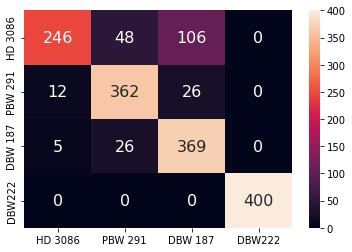

In [38]:
df_cm = pd.DataFrame(cm,index =[i for i in VARIETIES],columns=[i for i in VARIETIES])
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16},fmt='.0f') # font size

plt.show()